<a href="https://colab.research.google.com/github/addicted-ai/kaggle_practice/blob/main/titanic_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

import graphviz
from IPython.display import Image

In [2]:
# Reading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/addicted-ai/kaggle_practice/main/dataset/titanic/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/addicted-ai/kaggle_practice/main/dataset/titanic/test.csv')

In [3]:
# data to be used for training & with labeled dependent variable
df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [4]:
# test data that i have to get prediction & submit
test.head(4)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Categorical columns are `Name`, `Sex`, `Ticket`, `Cabin`, `Embarked`.
- Name column can't be used for model.

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
cat_col = ['Sex', 'Ticket', 'Cabin', 'Embarked']
for i in cat_col:
  print(i,':')
  display(df[i].value_counts(dropna=False))
  print('________\n')

Sex :


male      577
female    314
Name: Sex, dtype: int64

________

Ticket :


347082        7
1601          7
CA. 2343      7
347088        6
CA 2144       6
             ..
28425         1
370371        1
362316        1
PC 17610      1
A.5. 11206    1
Name: Ticket, Length: 681, dtype: int64

________

Cabin :


NaN            687
B96 B98          4
C23 C25 C27      4
G6               4
E101             3
              ... 
E68              1
A24              1
D10 D12          1
D50              1
B73              1
Name: Cabin, Length: 148, dtype: int64

________

Embarked :


S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

________



In [8]:
print('No of Unique values in Cabin:')
display(df['Cabin'].nunique())
print('No of Unique values in Ticket:')
display(df['Ticket'].nunique())

No of Unique values in Cabin:


147

No of Unique values in Ticket:


681

- Both Ticket & Cabin have very high no of level. We can't use them for training.
- 'Age' Columns seems to have ~20% NaN values. We can drop it.
- 'Embarked` column has 2 NaN values. We can impute NaN with mode of column.

In [9]:
df['Embarked'] = df['Embarked'].replace(np.nan, df['Embarked'].mode()[0])

In [10]:
df['Fare'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, .8, 0.9, 0.95, 0.97, 0.99, 1])

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
10%        7.550000
25%        7.910400
50%       14.454200
75%       31.000000
80%       39.687500
90%       77.958300
95%      112.079150
97%      151.550000
99%      249.006220
100%     512.329200
max      512.329200
Name: Fare, dtype: float64

In [11]:
df['Fare'].median()

14.4542

In [12]:
test['Fare'] = test['Fare'].replace(np.nan, df['Fare'].median())

In [13]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [14]:
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = pd.get_dummies(df[features])
X_test = pd.get_dummies(test[features])

y = df["Survived"]

In [15]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
hyper_params = {'max_depth': range(3, 20),
                'max_features': range(3, 17),
                'min_samples_leaf': range(2, 200, 10),
                'min_samples_split': range(2,50, 2),
                'n_estimators': range(20, 151, 5)}
model_rcv = RandomizedSearchCV(estimator=rf,
                               param_distributions=hyper_params,
                              return_train_score=True,
                              n_jobs=8, n_iter=200, verbose=1, cv=5)

In [17]:
model_rcv.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   48.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [18]:
model_rcv.best_score_

0.8092272926997678

In [19]:
rcv_df = pd.DataFrame(model_rcv.cv_results_)
rcv_df.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.172552,0.006332,0.108150,0.008883,20,48,32,3,11,"{'n_estimators': 20, 'min_samples_split': 48, ...",0.804469,0.792135,0.786517,0.752809,0.792135,0.785613,0.017422,73,0.782303,0.812062,0.786816,0.793829,0.799439,0.794890,0.010395
1,1.355739,0.130331,0.141503,0.006500,150,18,172,6,5,"{'n_estimators': 150, 'min_samples_split': 18,...",0.614525,0.640449,0.702247,0.780899,0.775281,0.702680,0.067872,95,0.727528,0.699860,0.702665,0.779804,0.687237,0.719419,0.032897
2,0.725983,0.078066,0.135384,0.005172,75,18,62,7,8,"{'n_estimators': 75, 'min_samples_split': 18, ...",0.804469,0.803371,0.786517,0.752809,0.786517,0.786737,0.018667,23,0.782303,0.782609,0.786816,0.795231,0.786816,0.786755,0.004666


In [20]:
sel_cols = ['param_max_depth','param_max_features','param_min_samples_leaf','param_n_estimators', 'rank_test_score',  'mean_test_score']
rcv_df.sort_values(by='rank_test_score')[sel_cols].head(20)

,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,rank_test_score,mean_test_score
10,9,8,2,70,1,0.809227
66,9,9,2,110,2,0.808104
140,13,8,12,125,3,0.806974
164,15,3,22,25,4,0.804708
16,5,6,2,80,5,0.802492
175,5,5,12,135,6,0.802473
88,5,4,12,20,6,0.802473
96,18,7,2,55,8,0.801368
115,18,9,32,55,9,0.801350
29,4,9,12,40,10,0.799127


In [21]:
hyper_params.keys()

dict_keys(['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'n_estimators'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


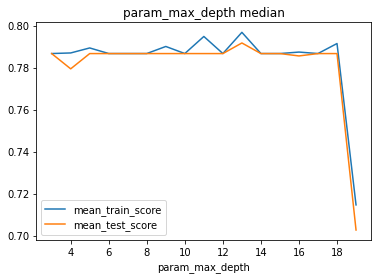

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


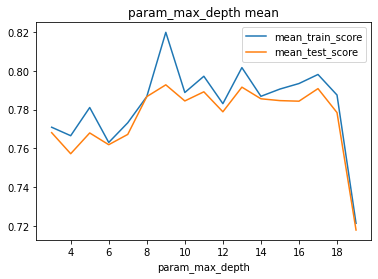

In [22]:
rcv_df.groupby('param_max_depth')['mean_train_score', 'mean_test_score'].agg(np.median).plot()
plt.title('param_max_depth median')
plt.show()
rcv_df.groupby('param_max_depth')['mean_train_score', 'mean_test_score'].mean().plot()
plt.title('param_max_depth mean')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


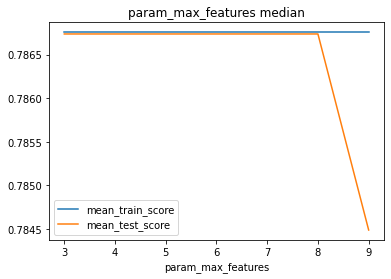

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


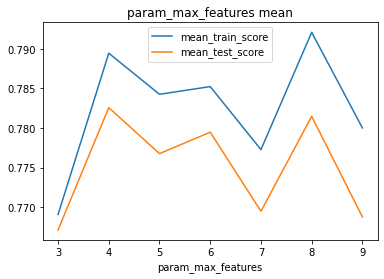

In [23]:
rcv_df.groupby('param_max_features')['mean_train_score', 'mean_test_score'].agg(np.median).plot()
plt.title('param_max_features median')
plt.show()
rcv_df.groupby('param_max_features')['mean_train_score', 'mean_test_score'].mean().plot()
plt.title('param_max_features mean')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


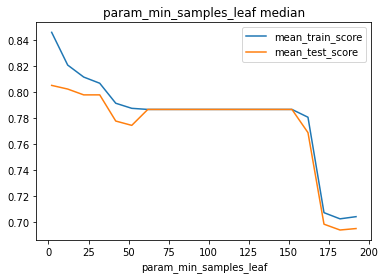

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


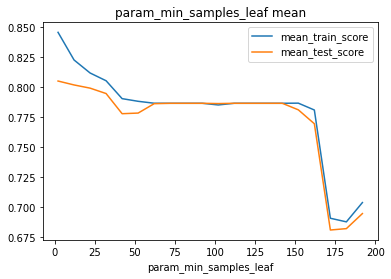

In [24]:
rcv_df.groupby('param_min_samples_leaf')['mean_train_score', 'mean_test_score'].agg(np.median).plot()
plt.title('param_min_samples_leaf median')
plt.show()
rcv_df.groupby('param_min_samples_leaf')['mean_train_score', 'mean_test_score'].mean().plot()
plt.title('param_min_samples_leaf mean')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


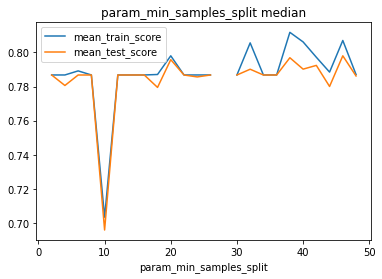

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


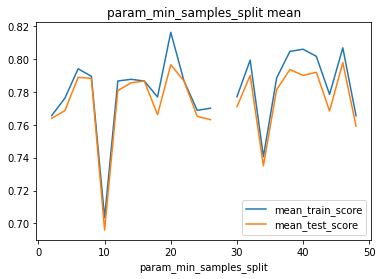

In [25]:
rcv_df.groupby('param_min_samples_split')['mean_train_score', 'mean_test_score'].agg(np.median).plot()
plt.title('param_min_samples_split median')
plt.show()
rcv_df.groupby('param_min_samples_split')['mean_train_score', 'mean_test_score'].mean().plot()
plt.title('param_min_samples_split mean')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


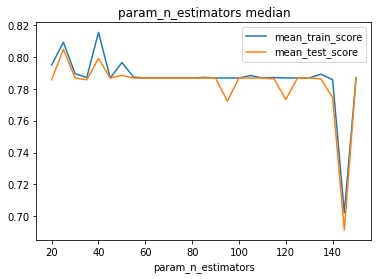

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


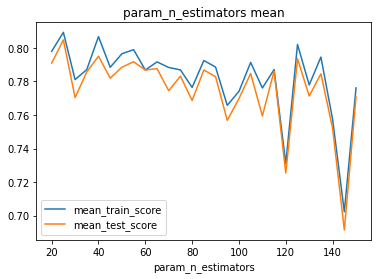

In [26]:
rcv_df.groupby('param_n_estimators')['mean_train_score', 'mean_test_score'].agg(np.median).plot()
plt.title('param_n_estimators median')
plt.show()
rcv_df.groupby('param_n_estimators')['mean_train_score', 'mean_test_score'].mean().plot()
plt.title('param_n_estimators mean')
plt.show()

In [38]:
params = {
    'max_depth': [12,13,14],
    'min_samples_leaf': [1,2],
    'min_samples_split': [12,13,14],
    'max_features': [4,5,6],
    'n_estimators': [90,95,100,105]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=params,
                           cv=3, 
                           n_jobs=4, 
                           verbose=1,
                           return_train_score=True,
                           scoring = "accuracy")
grid_search.fit(X, y)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 648 out of 648 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_estimator_)

In [39]:
print(grid_search.best_score_)
print(grid_search.best_estimator_)

0.8148148148148149
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [ ]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
sel_cols = ['param_max_depth','param_max_features','param_min_samples_leaf','param_n_estimators', 'rank_test_score',  'mean_test_score']

In [ ]:
cv_df = pd.DataFrame(grid_search.cv_results_)
cv_df.sort_values(by='rank_test_score')[sel_cols].head(20)

,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,rank_test_score,mean_test_score
1603,11,8,2,80,1,0.814815
2008,17,7,2,80,2,0.814810
1602,11,8,2,70,2,0.814810
3404,19,8,2,105,4,0.813694
2804,18,8,2,105,4,0.813694
1004,10,8,2,105,6,0.813689
1002,10,8,2,70,7,0.813684
3208,19,7,2,80,7,0.813684
2608,18,7,2,80,7,0.813684
1604,11,8,2,105,10,0.812573


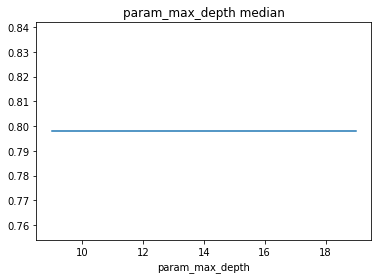

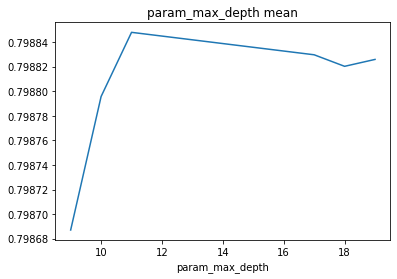

In [ ]:
cv_df.groupby('param_max_depth')['mean_test_score'].agg(np.median).plot()
plt.title('param_max_depth median')
plt.show()
cv_df.groupby('param_max_depth')['mean_test_score'].mean().plot()
plt.title('param_max_depth mean')
plt.show()

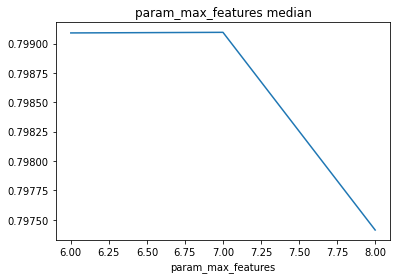

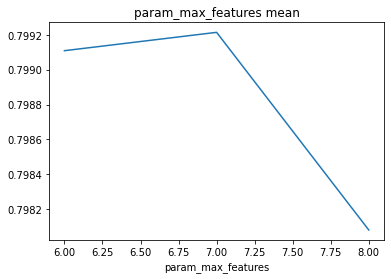

In [ ]:
cv_df.groupby('param_max_features')['mean_test_score'].agg(np.median).plot()
plt.title('param_max_features median')
plt.show()
cv_df.groupby('param_max_features')['mean_test_score'].mean().plot()
plt.title('param_max_features mean')
plt.show()

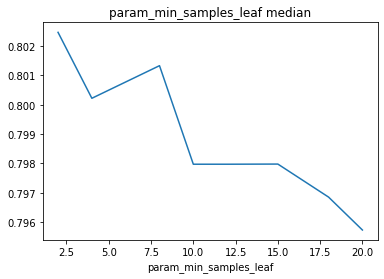

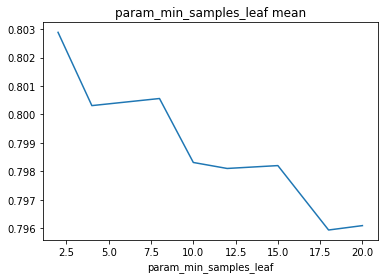

In [ ]:
cv_df.groupby('param_min_samples_leaf')['mean_test_score'].agg(np.median).plot()
plt.title('param_min_samples_leaf median')
plt.show()
cv_df.groupby('param_min_samples_leaf')['mean_test_score'].mean().plot()
plt.title('param_min_samples_leaf mean')
plt.show()

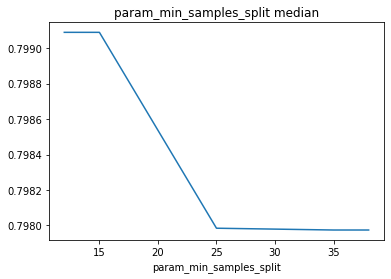

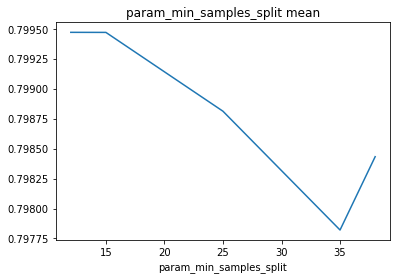

In [ ]:
cv_df.groupby('param_min_samples_split')['mean_test_score'].agg(np.median).plot()
plt.title('param_min_samples_split median')
plt.show()
cv_df.groupby('param_min_samples_split')['mean_test_score'].mean().plot()
plt.title('param_min_samples_split mean')
plt.show()

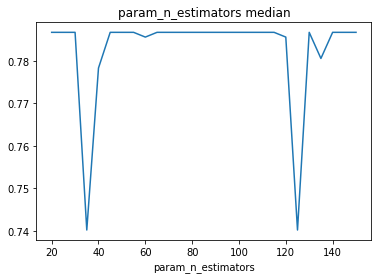

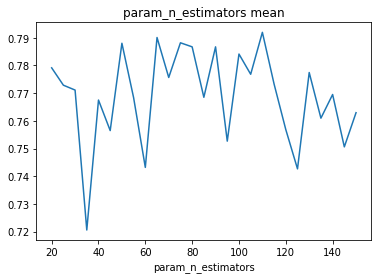

In [ ]:
rcv_df.groupby('param_n_estimators')['mean_test_score'].agg(np.median).plot()
plt.title('param_n_estimators median')
plt.show()
rcv_df.groupby('param_n_estimators')['mean_test_score'].mean().plot()
plt.title('param_n_estimators mean')
plt.show()

In [ ]:
def show_tree(model):
  dot_data = export_graphviz(model, out_file=None, 
                                feature_names=X.columns,  
                                class_names=['Survived', 'Not Survived'],
                                filled=True, rounded=True)
  graph = graphviz.Source(dot_data, format="png")
  # Image(graph.render("titanic_decision_tree")) # shows png file
  return graph.render("titanic_decision_tree")

In [ ]:
rf_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

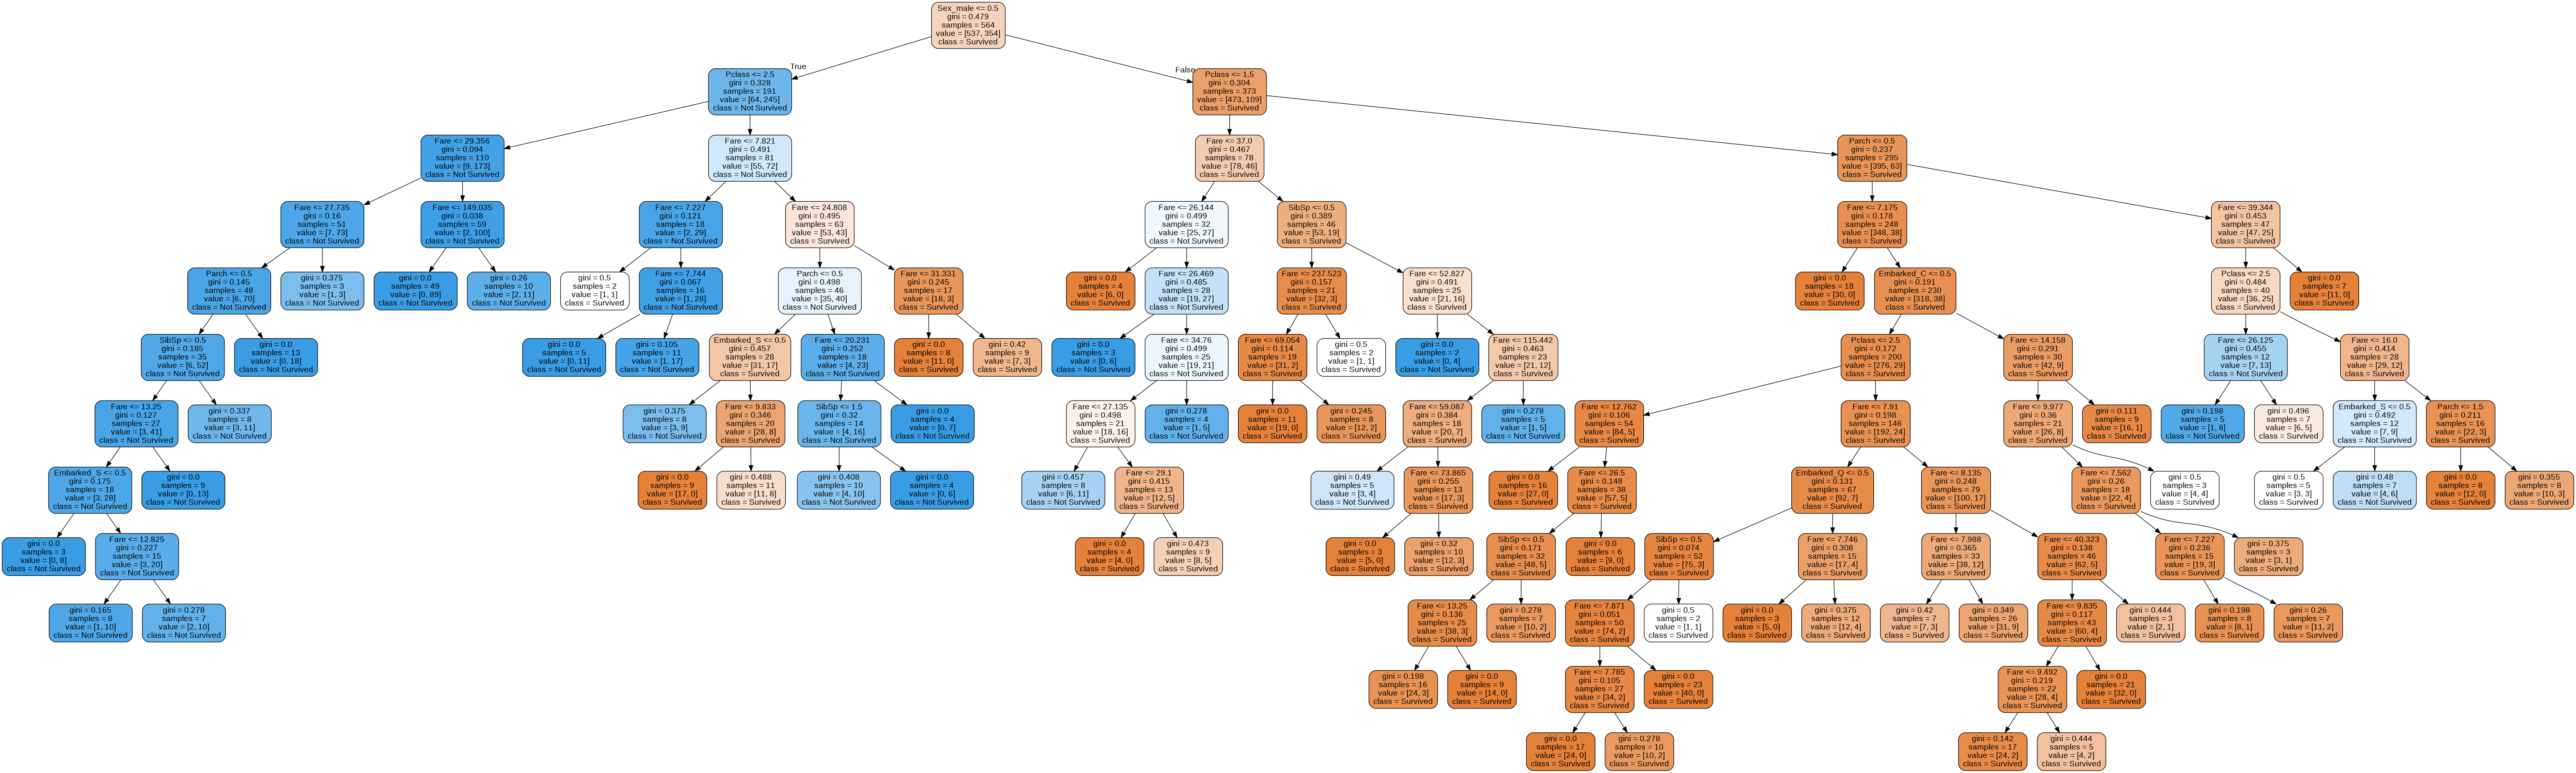

In [ ]:
sample_tree = rf_best.estimators_[0]
Image(show_tree(sample_tree))

In [ ]:
predictions = rf_best.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)